# Convolutional Neural Networks for CIFAR-10 Multiple Classes

In [1]:
import pandas as pd
import numpy as np

# The Data

CIFAR-10 is a dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 20s 0us/step


In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
x_train[0].shape

(32, 32, 3)

In [5]:
import matplotlib.pyplot as plt

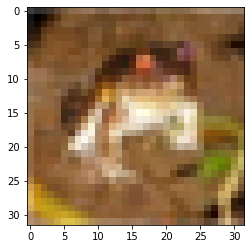

In [6]:
# FROG
plt.imshow(x_train[0])

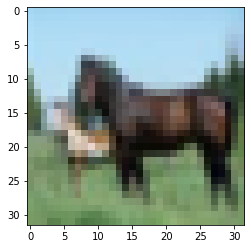

In [7]:
# HORSE
plt.imshow(x_train[12])

# PreProcessing

In [8]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [9]:
x_train[0].shape

(32, 32, 3)

In [10]:
x_train.max()

255

In [11]:
x_train = x_train/225

In [12]:
x_test = x_test/255

In [13]:
x_train.shape

(50000, 32, 32, 3)

In [14]:
x_test.shape

(10000, 32, 32, 3)

## Labels

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
y_train.shape

(50000, 1)

In [17]:
y_train[0]

array([6], dtype=uint8)

In [18]:
y_cat_train = to_categorical(y_train,10)

In [19]:
y_cat_train.shape

(50000, 10)

In [20]:
y_cat_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [21]:
y_cat_test = to_categorical(y_test,10)

----------
# Building the Model

In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten, concatenate, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [71]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)

In [48]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, min_lr=1e-7, verbose = 1, patience=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=2)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_loss', mode='min', verbose = 1, save_best_only=True)

In [29]:
model = Sequential(name = 'Base_cnn')

## FIRST SET OF LAYERS

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

## SECOND SET OF LAYERS

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
model.add(Flatten())

# 256 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(256, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [53]:
def build_model(lr = 0.0, lr_d = 0.0, dr = 0.0):
    x = Input(shape = (32, 32, 3))
    conv = Conv2D(32, kernel_size=(4, 4), activation='relu')(x)
    
    mp = MaxPooling2D(pool_size=(2, 2))(conv)
    ap = AveragePooling2D(pool_size=(2, 2))(conv)
    flat = concatenate([mp, ap])
    flat = Flatten()(flat)
    
    max_pool = GlobalMaxPooling2D()(conv)
    avg_pool = GlobalAveragePooling2D()(conv) 
    
    y = concatenate([flat, max_pool, avg_pool])
    y = Dropout(dr)(Dense(32, activation='relu')(y))
    y = Dense(10, activation = 'softmax')(y)
    
    model = Model(inputs = x, outputs = y, name = 'comb_local_global')
    opt = tf.keras.optimizers.Adam(lr = lr, decay = lr_d)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [75]:
def build_model(lr = 0.0, lr_d = 0.0, dr = 0.0):
    model = Sequential(name = 'rnn_deep')
    model.add(Conv2D(32, (3,3), input_shape=(32, 32, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    opt = tf.keras.optimizers.Adam(lr = lr, decay = lr_d)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [76]:
model = build_model(lr = 0.001, lr_d = 0, dr = 0)

In [77]:
model.summary()

Model: "rnn_deep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0  

In [78]:
model.fit(x_train,y_cat_train,
          validation_data = (x_test,y_cat_test),
          batch_size = 256, epochs=400,
          callbacks = [rlr, es, mc])

Train on 50000 samples, validate on 10000 samples
Epoch 1/400
49920/50000 [============================>.] - ETA: 1s - loss: 1.9198 - accuracy: 0.4183
Epoch 00001: val_loss did not improve from 1.01936
50000/50000 [==============================] - 929s 19ms/sample - loss: 1.9188 - accuracy: 0.4185 - val_loss: 4.2411 - val_accuracy: 0.1001
Epoch 2/400
  768/50000 [..............................] - ETA: 15:17 - loss: 1.3615 - accuracy: 0.5234WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


KeyboardInterrupt: 

In [60]:
# Careful, don't overwrite our file!
# model.save('cifar_10epochs.h5')

In [61]:
losses = pd.DataFrame(model.history.history)

In [62]:
losses.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,1.671996,0.40306,1.448027,0.4788,0.001
1,1.318492,0.53558,1.269590,0.5633,0.001
2,1.207930,0.57880,1.222714,0.5731,0.001
3,1.141028,0.60300,1.208523,0.5793,0.001
4,1.092921,0.62288,1.185115,0.5795,0.001


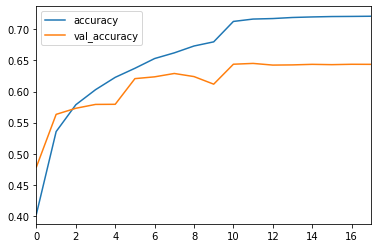

In [63]:
losses[['accuracy','val_accuracy']].plot()

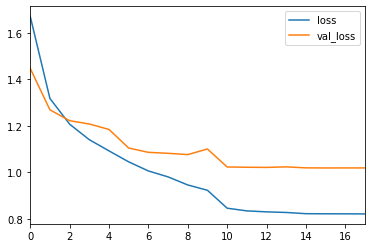

In [64]:
losses[['loss','val_loss']].plot()

In [65]:
model.metrics_names

['loss', 'accuracy']

In [66]:
print(model.metrics_names)
print(model.evaluate(x_test,y_cat_test,verbose=0))

['loss', 'accuracy']
[1.019524402999878, 0.6438]


In [39]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict_classes(x_test)

In [40]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.60      0.70      1000
           1       0.85      0.69      0.76      1000
           2       0.62      0.47      0.53      1000
           3       0.43      0.52      0.47      1000
           4       0.51      0.73      0.60      1000
           5       0.57      0.56      0.56      1000
           6       0.56      0.87      0.68      1000
           7       0.82      0.63      0.71      1000
           8       0.72      0.81      0.76      1000
           9       0.87      0.55      0.67      1000

    accuracy                           0.64     10000
   macro avg       0.68      0.64      0.65     10000
weighted avg       0.68      0.64      0.65     10000



In [41]:
confusion_matrix(y_test,predictions)

array([[605,  13,  73,  45,  64,  20,  40,   8, 114,  18],
       [ 18, 694,  11,  38,  26,  18,  61,   9,  78,  47],
       [ 37,   3, 472,  93, 158,  73, 135,  19,   7,   3],
       [  3,   2,  47, 517, 107, 146, 151,  18,   7,   2],
       [  7,   1,  38,  53, 729,  35,  95,  28,  13,   1],
       [  4,   1,  41, 193,  91, 560,  83,  21,   5,   1],
       [  1,   1,  23,  47,  42,  15, 868,   1,   1,   1],
       [  6,   1,  18,  99, 154,  69,  21, 626,   4,   2],
       [ 35,  10,  22,  45,  34,  14,  23,   3, 806,   8],
       [ 22,  90,  20,  84,  27,  39,  66,  29,  78, 545]], dtype=int64)

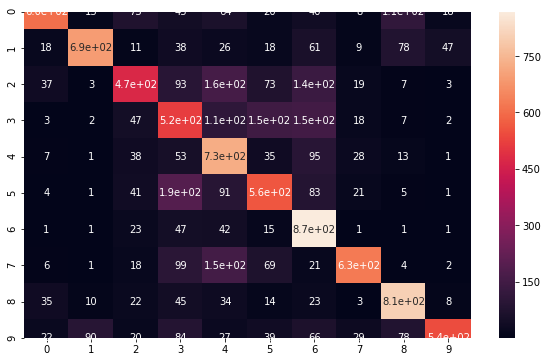

In [42]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True);
# https://github.com/matplotlib/matplotlib/issues/14751

# Predicting a given image

In [43]:
my_image = x_test[16]

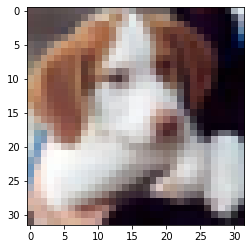

In [44]:
plt.imshow(my_image)

In [45]:
# SHAPE --> (num_images,width,height,color_channels)
model.predict_classes(my_image.reshape(1,32,32,3))

array([5], dtype=int64)

In [46]:
# 5 is DOG
# https://www.cs.toronto.edu/~kriz/cifar.html